Zadanie 1

0.0 1.0 (-8107.579104875637-1055.896528072688j) (118979.52446524991+0j)
(512, 512) (512, 512)


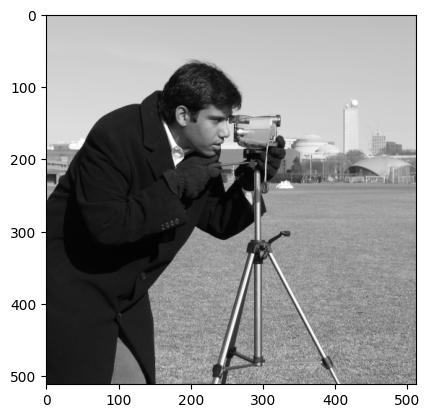

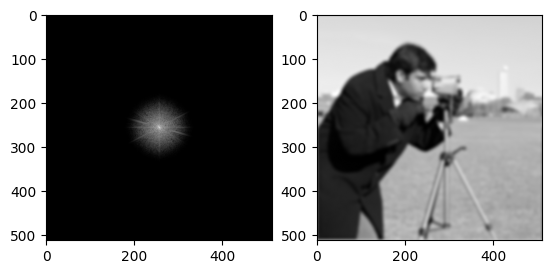

In [11]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import cv2

camera = skimage.data.camera() / 255.0
plt.imshow(camera,cmap='gray')

ff = np.fft.fft2(camera)
ff = np.fft.fftshift(ff)
mask = np.zeros_like(camera)
cv2.circle(mask, (mask.shape[1]//2,mask.shape[0]//2),32,1,-1)
mask  = skimage.filters.gaussian(mask,sigma=15)
ff = ff * (mask)
ff = np.fft.ifftshift(ff)
iff = np.fft.ifft2(ff)

print(camera.min(),camera.max(), ff.min(), ff.max())
print(camera.shape, ff.shape)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(np.log1p(np.abs(np.fft.fftshift(ff))),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.log1p(np.abs(iff)),cmap='gray')
plt.show()


Zadanie 2

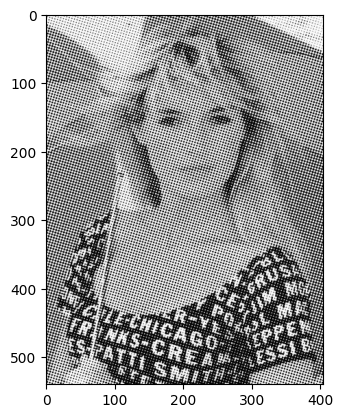

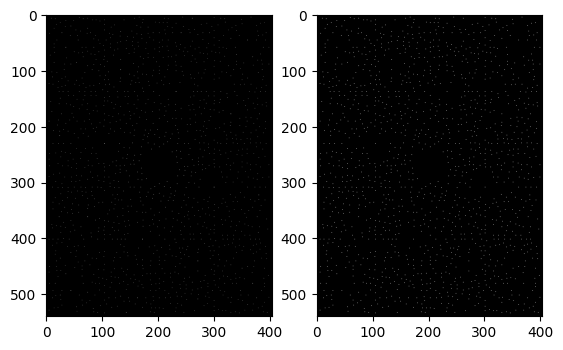

In [18]:
woman= skimage.io.imread('dane/gray1.jpg') / 255.0

plt.imshow(woman, cmap='gray')

ff_w = np.fft.fft2(woman)
ff_w = np.fft.fftshift(ff_w)
mask_w = np.zeros_like(woman)
cv2.circle(mask_w, (mask_w.shape[1]//2,mask_w.shape[0]//2),32,1,-1)

new_mask = np.zeros_like(woman)
for_local_maxima = ff_w * (1 - mask_w)
cords = skimage.feature.peak_local_max(np.abs(for_local_maxima), min_distance=5)
for c in cords:
    new_mask[c[0],c[1]] = 1


#new_mask  = skimage.filters.gaussian(new_mask,sigma=15)
ff_w = ff_w * (new_mask)
ff_w = np.fft.ifftshift(ff_w)
iff_w = np.fft.ifft2(ff_w)

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(np.log1p(np.abs(np.fft.fftshift(ff_w))),cmap='gray')
plt.subplot(1,2,2)
#plt.imshow(np.log1p(np.abs(iff_w)),cmap='gray')
plt.imshow(new_mask,cmap='gray')
plt.show()



In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

def auto_fft_denoise_peak_local_max(img_path, min_distance=10, relative_threshold=0.98, suppression_factor=0.5, show=True):
    """
    Automatyczna filtracja w dziedzinie Fouriera z użyciem peak_local_max.

    Parametry:
        img_path (str) – ścieżka do pliku obrazu
        min_distance (int) – minimalna odległość między lokalnymi maksimami
        relative_threshold (float) – próg (0–1) w relacji do wartości maksymalnej widma
        suppression_factor (float) – współczynnik przyciemnienia punktów (0–1)
        show (bool) – czy wyświetlić wykresy

    Zwraca:
        img_filtered (np.ndarray) – obraz po filtracji FFT
    """
    # Wczytaj obraz w skali szarości
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Nie udało się wczytać obrazu.")

    # --- FFT ---
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)
    log_magnitude = np.log1p(magnitude)  # dla lepszej wizualizacji

    # --- Znajdź lokalne maksima w widmie ---
    threshold_abs = relative_threshold * log_magnitude.max()
    coords = peak_local_max(log_magnitude, min_distance=min_distance, threshold_abs=threshold_abs)

    # --- Stłumienie znalezionych punktów ---
    mag_mod = magnitude.copy()
    for (y, x) in coords:
        # lokalne przyciemnienie wokół punktu (np. kwadrat 5x5)
        r = 5
        y1, y2 = max(0, y-r), min(mag_mod.shape[0], y+r)
        x1, x2 = max(0, x-r), min(mag_mod.shape[1], x+r)
        mag_mod[y1:y2, x1:x2] *= suppression_factor

    # --- Połącz z fazą i wykonaj odwrotną FFT ---
    phase = np.angle(fshift)
    f_new = mag_mod * np.exp(1j * phase)

    f_ishift = np.fft.ifftshift(f_new)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # --- Wizualizacja ---
    if show:
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Oryginalny obraz")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(log_magnitude, cmap='gray')
        plt.scatter(coords[:, 1], coords[:, 0], c='r', s=10)
        plt.title("Widmo Fouriera z lokalnymi maksimami")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(img_back, cmap='gray')
        plt.title("Po filtracji (FFT + peak_local_max)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return img_back
